Comparison of Disaster tweets : 
The aim of this notebook is to classify tweets potentially related to catastrophes into real or misleading tweets. Here comparison between several ML techniques will be also done.

In [105]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import string
import nltk
import re # regular expressions

import time
import numpy as np

In [5]:
#!pip install pyspellchecker

In [6]:
#from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.feature_selection import SelectPercentile

# pip install xgboost
import xgboost
from xgboost import XGBClassifier

In [7]:
import spacy
from spacy.lang.en import English

In [8]:
import string

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arijit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
#!ls sample_data

In [11]:
#!cp test.csv train.csv sample_data

In [12]:
# training data
data = pd.read_csv('train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
train_len = len(data)

In [14]:
# test data
tdata = pd.read_csv('test.csv')
tdata.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [15]:
print('training data shape: {}, test data shape: {}'.format(data.shape, tdata.shape))

training data shape: (7613, 5), test data shape: (3263, 4)


In [16]:
#combine training & test data, but dont shuffale
total_data = pd.concat([data, tdata], sort=False)
total_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [17]:
# check the missing data 
total_data.isnull().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

In [18]:
# so there are lot of missing values

In [19]:
print('unique values in keyword {}, location {}'.format(total_data.keyword.nunique(), total_data.location.nunique()))

unique values in keyword 221, location 4521


In [20]:
# check the distribution of target if there they are uneven 
def show_target_barplot():
  """ plot target distribution """
  target_types = data.target.value_counts()
  plot = sb.barplot(y=target_types, x=data.target.value_counts().index)
  plot.set_title('target distribution')

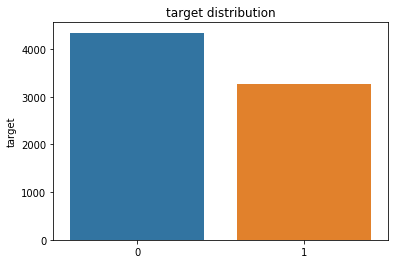

In [21]:
show_target_barplot()

'target' type counts looks to be not too deviated.

In [22]:
# Analyze the keyword & location feature and fill the missing values
def plot_keyword_location():
  fig, ax =plt.subplots(1,2)
  fig.subplots_adjust(hspace=0.5 , wspace=0.5)

  target_types = data.keyword.value_counts()[:10]
  # check for first few common names
  plot = sb.barplot(x=target_types, y=data.keyword.value_counts()[:10].index, ax=ax[0])
  plot.set_title('keyword types')

  location_types = data.location.value_counts()[:10]
  plot2 = sb.barplot(x=location_types, y=data.location.value_counts()[:10].index, ax=ax[1])
  plot2.set_title('location types')

  fig.show()

C:\Users\arijit\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


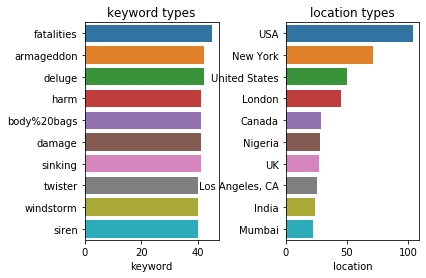

In [23]:
plot_keyword_location()

In [24]:
def fill_misiing_val():
  """ fill missing values with None """
  total_data.location.fillna('None', inplace=True)
  total_data.keyword.fillna('None', inplace=True)

  total_data.target.fillna(0, inplace=True)

fill_misiing_val()

In [25]:
total_data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [26]:
total_data.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,None,None,Forest fire near La Ronge Sask. Canada,1.0
2,5,None,None,All residents asked to 'shelter in place' are ...,1.0
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1.0


Data is now ready for cleaning

This data is having all weblinks and spaces as well
*   Need to clean the text *data*
*   remove punctuations
*   List item
*   lower case 
*   remove 







In [27]:
def remove_punctuations_and_nums(text):
  """ remove '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' and numbers """
  clean_data = ''.join([x for x in text if x not in string.punctuation])
  clean_data = ''.join([x for x in clean_data if x not in string.digits])
  return clean_data

def remove_stopwords(text):
  clean_data = ''.join([x for x in text if x not in nltk.corpus.stopwords.words('english')])
  return clean_data

def remove_weblinks(text):
  clean_data = re.sub('www.|https://|http://|.com|t.co/','', text)
  return clean_data

def remove_nonascii(text):
  clean_text = ''.join([x for x in text if ord(x) < 128])
  return clean_text

#spell = SpellChecker()
def correct_spelling(text):
  """ spelling correction """
  mispelled = spell.unknown(text.split())

  correct_text = []
  for word in text.split():
    if word in mispelled:
      correct_text.append(spell.correction(word))
    else:
      correct_text.append(word)

  return correct_text

def clean_text(data):
  # convert to lower case
  data['clean_text'] = data['text'].apply(lambda x: x.lower())
  print('lower case')
  # remove punc & digits
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_punctuations_and_nums(x))
  # remove stopwords
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_stopwords(x))
  # remove all web links
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_weblinks(x)) # takes time
  # remove non ascii charecters
  data['clean_text'] = data['clean_text'].apply(lambda x: remove_nonascii(x))
  # removing any leading and trailing whitespaces including tabs
  #data['clean_text'] = data['clean_text'].apply(lambda x: x.strip())

  # correct spelling
  # data['clean_text'] = data['clean_text'].apply(lambda x: correct_spelling(x)) #takes time to process
  
  # Lemmatization TBD
  

In [28]:
clean_text(total_data)

lower case


In [29]:
total_data.head()

,id,keyword,location,text,target,clean_text
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1.0,ur ee re he ren f h erhquke llh frgve u ll
1,4,None,None,Forest fire near La Ronge Sask. Canada,1.0,fre fre ner l rnge k cn
2,5,None,None,All residents asked to 'shelter in place' are ...,1.0,ll reen ke heler n plce re beng nfe b ffcer n...
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0,peple receve wlfre evcun rer n clfrn
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1.0,ju g en h ph fr rub lk ke fr wlfre pur n chl


In [30]:
#save the cleaned data for future processing
total_data.to_csv('cleaned_data.csv')

In [31]:
# vectorize
def vectorize_text(text):
  # just skipping CountVectorizer 
  vec = TfidfVectorizer() #CountVectorizer() #TfidfVectorizer()
  vectorized_text = vec.fit_transform(text)
  return vec, vectorized_text

In [32]:
# Define a metrics function named get_metrics to evaluate the model's performance
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [33]:
def scaled_data(X, X_valid):
    from sklearn.preprocessing import StandardScaler
    scaler_X = StandardScaler()
    X = scaler_X.fit_transform(X)
    X_valid = scaler_X.transform(X_valid)
    return X, X_valid, scaler_X  

In [34]:
"""
model_type : 
1 - Random forest(default)
2 - RidgeClassifier
3 - SVC
4 - Naive Bayes classifier
5 - xgboost 

TBD:
Parameter fine tuning
"""
#create a traditional sklearn model
def create_model(X, y, train_len, model_type=1):

  # split
  X_train = X[:train_len]
  X_test = X[train_len:]
  y_train = y[:train_len]
  y_test = y[train_len:]
  y_predict = []
  #X_train, X_test, y_train, y_test = train_test_split()
  # vectorize
  vec, X_train = vectorize_text(X_train)
  X_test = vec.transform(X_test)

  #X_Train, X_valid, scaler_X = scaled_data(X_train, X_test)
  #X_Test = scaler_X.transform(X_test)
    
  if model_type == 1: #RF classifier
    #model = RandomForestClassifier(n_estimators=100, random_state=21, max_depth=5)
    model = RandomForestClassifier(random_state=21)
    model.fit(X_train, y_train)
    cval = cross_val_score(model, X_train, y_train, scoring = 'balanced_accuracy', cv = 3)
    y_predict = model.predict(X_test)
    
  elif model_type == 2: #RidgeClassifier
    model = RidgeClassifier(random_state=21)
    model.fit(X_train, y_train)
    cval = cross_val_score(model, X_train, y_train, scoring = 'balanced_accuracy', cv = 3)
    y_predict = model.predict(X_test)
    
  elif model_type == 3: #SVC
    model = SVC(C=1.0, kernel='rbf',random_state=21)
    model.fit(X_train, y_train)
    cval = cross_val_score(model, X_train, y_train, scoring = 'balanced_accuracy', cv = 3)
    y_predict = model.predict(X_test)
    
  elif model_type == 4: #Naive Bayes classifier
    model = GaussianNB()

    X_train_transform = X_train.toarray()
    X_test_transform = X_test.toarray()
    
    model.fit(X_train_transform, y_train)
    y_predict = model.predict(X_test_transform)
    cval = cross_val_score(model, X_train_transform, y_train, scoring = 'balanced_accuracy', cv = 3)
    
  elif model_type == 5: # xgboost classifier
    model = XGBClassifier()
    model.fit(X_train, y_train)
    cval = cross_val_score(model, X_train, y_train, scoring = 'balanced_accuracy', cv = 3)
    y_predict = model.predict(X_test)
    
  print("cross validation score:{}".format(cval))
  #accuracy, precision, recall, f1 = get_metrics(y_test, y_predict)  
  #print("accuracy {}, precision {}, recall {}, f1 {}".format(accuracy, precision, recall, f1))
  
  return y_predict

In [35]:
#read the saved data 
df = pd.read_csv('cleaned_data.csv')
X = df['clean_text']
y = df['target']

from datetime import datetime
time_start = datetime.now()

y_predict = create_model(X, y, train_len, 1) # random forest

#y_predict = create_model(X, y, train_len, 2) #RidgeClassifier

#y_predict = create_model(X, y, train_len, 3) #svc

#y_predict = create_model(X, y, train_len, 4) # naive bayes

#y_predict = create_model(X, y, train_len, 5) #xgboost 

time_delta = datetime.now()-time_start
print('time:',time_delta)

cross validation score:[0.65031701 0.59945385 0.64872847]
time: 0:00:51.309460


In [36]:
#write the predictions to a file
predict = pd.DataFrame({'text':tdata['text'], 'prediction':y_predict})
predict.to_csv('final_prediction.csv')


*Use SpaCy:*
spacy has preloaded english library and it understand the stop words etc.

In [37]:
spacy_nlp = spacy.load('en_core_web_lg')

In [38]:
# remove stop words
def rem_stopw(text):
    clean_text = "".join()

In [39]:
print('spaCy Version: %s' % (spacy.__version__))

spaCy Version: 2.2.3


In [40]:
spacy_stopw = spacy.lang.en.STOP_WORDS

In [41]:
def remove_stopw(text):
    tokens = [token.text for token in text if not token.is_stop]
    return ' '.join([token for token in tokens])

def text_lammatize(text):
    tokens = [token.lemma_ for token in text]
    return ' '.join([token for token in tokens])

def remove_punctuations(text):
    punctuations = string.punctuation
    tokens = [word for word in text if not punctuations]
    return tokens
#' '.join([token for token in tokens])

In [44]:
#spacy_tokenizer(sample_text)

def clean_text_spacy(df):
    df['clean_text'] = df['text'].apply(lambda x: x.lower())
    df['clean_text'] = df['clean_text'].apply(lambda x: remove_stopw(spacy_nlp(x)))
    df['clean_text'] = df['clean_text'].apply(lambda x: text_lammatize(spacy_nlp(x)))
    df['clean_text'] = df['clean_text'].apply(lambda x: remove_weblinks(x))                

clean_text_spacy(total_data)

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [47]:
punctuations = string.punctuation

perser = English()

from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

def spacy_tokenizer(string):
    mtoken = perser(string) 
    #lammatization 
    mtoken = [word.lemma_.lower() if word.lemma_ != "-PRON-" else word.lower_ for word in mtoken]
    # remove stop words and punctuations
    mtoken = [word for word in mtoken if word not in stopwords and word not in punctuations]
    
    return mtoken

In [48]:
#Custom transformer using spaCy 
def clean_text(text):
    """Basic function to clean the text"""
    return text.strip().lower()
    

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        print('predictors->transform')
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        print('predictors->fit')
        return self
    def get_params(self, deep=True):
        return {}

In [49]:
classifier = RandomForestClassifier(random_state=21)
tfvenctorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)

pipe = Pipeline([('cleaner', predictors()),
                ('vectorizer', tfvenctorizer),
                ('classifier', classifier)
                ])

In [ ]:
X_train = data['text']
y_train = data['target']
pipe.fit(X_train, y_train)

In [ ]:
X_test = tdata['text']
prediction = pipe.predict(X_test)

In [ ]:
# create a csv for the predictions
pred = pd.DataFrame({'text':X_test, 'prediction':prediction})

In [ ]:
pred.to_csv('pred_spacy.csv')

Use Deep learning using TensorFlow Keras

In [50]:
import tensorflow as tf

In [100]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

In [72]:
def clean_text_for_deeplearning(tfdata):
    tfdata['clean_text_tf'] = tfdata['text'].apply(lambda x: x.lower())
    
    tfdata['clean_text_tf'] = tfdata['clean_text_tf'].apply(lambda x: remove_punctuations_and_nums(x))

In [73]:
total_data.head()

,id,keyword,location,text,target,clean_text
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this earthquake ma...
1,4,None,None,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask canada
2,5,None,None,All residents asked to 'shelter in place' are ...,1.0,all residents asked to shelter in place are be...
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0,people receive wildfires evacuation orders in...
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby alaska as s...


In [74]:
clean_text_for_deeplearning(total_data)

In [75]:
total_data.head()

,id,keyword,location,text,target,clean_text,clean_text_tf
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this earthquake ma...,our deeds are the reason of this earthquake ma...
1,4,None,None,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,None,None,All residents asked to 'shelter in place' are ...,1.0,all residents asked to shelter in place are be...,all residents asked to shelter in place are be...
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1.0,people receive wildfires evacuation orders in...,people receive wildfires evacuation orders in...
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska as s...


In [65]:
# tokenize
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

In [76]:
tokenizer.fit_on_texts(total_data['clean_text_tf'][:train_len])

In [80]:
windex = tokenizer.word_index

In [81]:
len(windex)

21826

In [86]:
iterator=iter(windex.items())
for i in range(5):
    print(next(iterator))

('<OOV>', 1)
('the', 2)
('a', 3)
('in', 4)
('to', 5)


In [84]:
type(windex)

dict

In [87]:
train_data_seq = tokenizer.texts_to_sequences(total_data['clean_text_tf'][:train_len])

In [88]:
train_data_seq[:10]

[[110, 4404, 22, 2, 821, 6, 19, 237, 124, 1539, 4405, 67, 39],
 [178, 43, 216, 651, 6605, 6606, 1330],
 [39,
  1664,
  1540,
  5,
  2047,
  4,
  652,
  22,
  121,
  6607,
  18,
  1665,
  41,
  412,
  238,
  54,
  2047,
  4,
  652,
  1331,
  22,
  1052],
 [57, 4406, 1332, 238, 1331, 4, 87],
 [29, 94, 1159, 19, 318, 20, 6608, 2048, 26, 252, 20, 1332, 6609, 66, 3, 175],
 [2766, 384, 87, 1427, 822, 4, 631, 6610, 523, 5, 1105, 366, 43, 4407, 1332],
 [209, 73, 823, 280, 1160, 785, 239, 6, 1666, 4, 6611, 990, 2328, 1541],
 [33, 11, 214, 6, 2, 1847, 7, 8, 71, 101, 3, 43, 4, 2, 4408],
 [273, 42, 72, 238, 1240, 50, 4, 2, 555, 824, 2, 702],
 [33, 2329, 16, 2, 524, 9, 231, 5, 110, 350]]

In [89]:
# check the length of the text messages to decide the max length to keep.
txt_len=[]
for text in total_data['clean_text_tf']:
    txt_len.append(len(text))

In [90]:
txt_len[:10]

[68, 37, 130, 58, 86, 101, 92, 55, 78, 48]

In [91]:
import seaborn as sb

Text(0.5, 1.0, 'text msg length distribution')

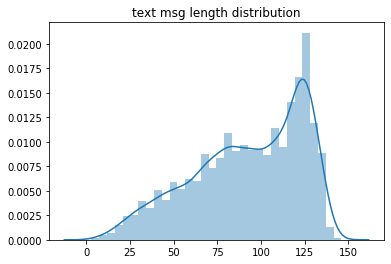

In [94]:
sb.distplot(txt_len, label='text msg length').set_title('text msg length distribution')

In [98]:
# we can cut of the length at 150
"""Signature:
pad_sequences(
    sequences,
    maxlen=None,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0.0,
)
"""
train_data_padded = pad_sequences(train_data_seq, maxlen=150, padding='post', truncating='post')
#train_data_padded[:10]

array([[ 110, 4404,   22, ...,    0,    0,    0],
       [ 178,   43,  216, ...,    0,    0,    0],
       [  39, 1664, 1540, ...,    0,    0,    0],
       ...,
       [  33,   11,  214, ...,    0,    0,    0],
       [ 273,   42,   72, ...,    0,    0,    0],
       [  33, 2329,   16, ...,    0,    0,    0]])

In [99]:
test_data_seq = tokenizer.texts_to_sequences(total_data['clean_text_tf'][train_len:])
test_data_padded = pad_sequences(test_data_seq, maxlen=150, padding='post', truncating='post')

In [102]:
vocab_size = 10000
# make a model
model = keras.Sequential()
#Turns positive integers (indexes) into dense vectors of fixed size.
model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                 output_dim=16,
                                 input_length=150))
                                 
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(units=24, activation='relu'))
                                 
# o/p layer                                
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

In [103]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [108]:
history = model.fit(x=np.array(train_data_padded), y=np.array(total_data['target'][:train_len]), epochs=8, 
         validation_data=(np.array(test_data_padded), np.array(total_data['target'][train_len:])), verbose=2)

Train on 7613 samples, validate on 3263 samples
Epoch 1/8
7613/7613 - 1s - loss: 0.2718 - accuracy: 0.8922 - val_loss: 1.2095 - val_accuracy: 0.5939
Epoch 2/8
7613/7613 - 1s - loss: 0.2502 - accuracy: 0.9045 - val_loss: 1.1195 - val_accuracy: 0.6454
Epoch 3/8
7613/7613 - 1s - loss: 0.2342 - accuracy: 0.9105 - val_loss: 1.4329 - val_accuracy: 0.5590
Epoch 4/8
7613/7613 - 1s - loss: 0.2195 - accuracy: 0.9165 - val_loss: 1.1377 - val_accuracy: 0.6687
Epoch 5/8
7613/7613 - 1s - loss: 0.2028 - accuracy: 0.9217 - val_loss: 1.2916 - val_accuracy: 0.6322
Epoch 6/8
7613/7613 - 1s - loss: 0.1887 - accuracy: 0.9278 - val_loss: 1.4014 - val_accuracy: 0.6191
Epoch 7/8
7613/7613 - 1s - loss: 0.1768 - accuracy: 0.9327 - val_loss: 1.7909 - val_accuracy: 0.5133
Epoch 8/8
7613/7613 - 1s - loss: 0.1681 - accuracy: 0.9373 - val_loss: 1.4638 - val_accuracy: 0.6255
